In [1]:
!pip install fastai==1.0.42

    100% |████████████████████████████████| 163kB 1.5MB/s ta 0:00:01
  Found existing installation: fastai 1.0.45
    Uninstalling fastai-1.0.45:
      Successfully uninstalled fastai-1.0.45
You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [4]:
base_image_dir = "../input/dr-augmentedr/dr/upload/"
df = pd.read_csv("../input/dr-augmentedr/dr.csv")
df.columns = ['image', 'level']
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.png'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,4,../input/dr-augmentedr/dr/upload/16114_right -...
1,3,../input/dr-augmentedr/dr/upload/25733_left.png
2,2,../input/dr-augmentedr/dr/upload/20060412_5212...
3,1,../input/dr-augmentedr/dr/upload/20060412_6129...
4,1,../input/dr-augmentedr/dr/upload/20051020_6499...
5,0,../input/dr-augmentedr/dr/upload/20051130_5432...
6,1,../input/dr-augmentedr/dr/upload/20060412_6039...
7,4,../input/dr-augmentedr/dr/upload/IM003359.png
8,3,../input/dr-augmentedr/dr/upload/21796_right.png
9,2,../input/dr-augmentedr/dr/upload/IM001866.png


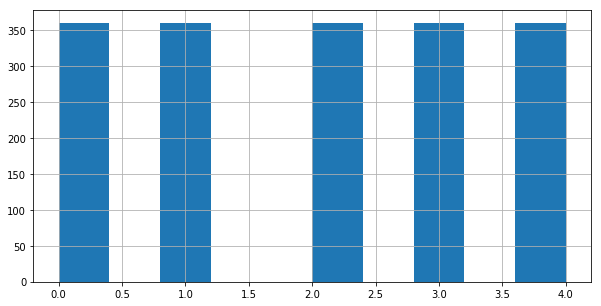

In [5]:
df['level'].hist(figsize = (10, 5))

In [6]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,360
1,360
2,360
3,360
4,360


In [7]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

360

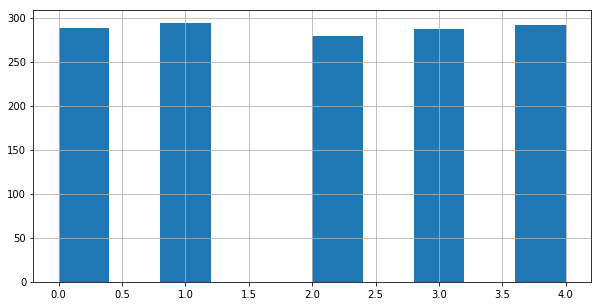

In [9]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [10]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,288
1,294
2,279
3,287
4,292


In [11]:
train_df.pivot_table(index='level', aggfunc=len).max().max()

294

New Data Size: 2940 Old Size: 1440


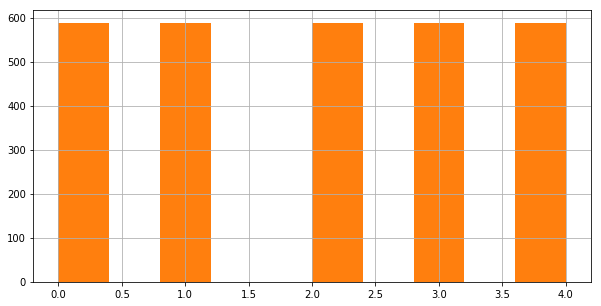

In [12]:
train_df = balance_data(2*train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [13]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

3300

In [14]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

300 300


In [15]:
bs = 32 #smaller batch size is better for training, but may take longer
sz=256

In [16]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

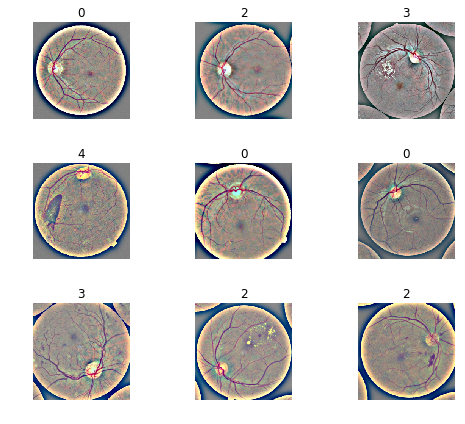

In [17]:
data.show_batch(rows=3, figsize=(7,6))

In [18]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4]


(5, 5)

In [19]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),device='cuda:0')

In [20]:
import torchvision
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 67818500.17it/s]


In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


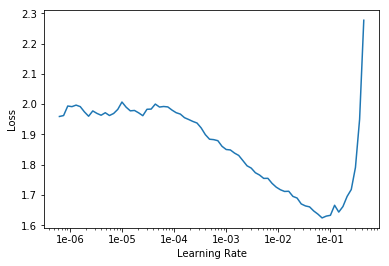

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(8,max_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,1.345364,1.104181,0.479224,0.734003
2,1.037493,0.932919,0.581717,0.814712
3,0.852713,0.924458,0.626039,0.833524
4,0.710846,0.887703,0.612188,0.847436
5,0.641358,0.785758,0.653740,0.875745
6,0.563076,0.742186,0.689751,0.887490
7,0.503912,0.728551,0.698061,0.891725
8,0.468544,0.734066,0.698061,0.887257


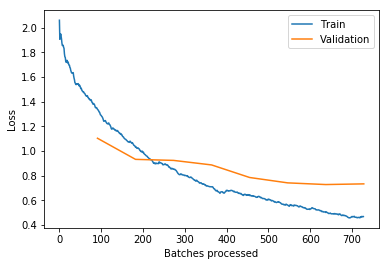

In [24]:
learn.recorder.plot_losses()

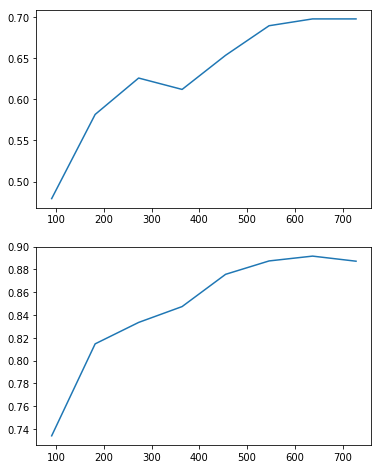

In [25]:
learn.recorder.plot_metrics()

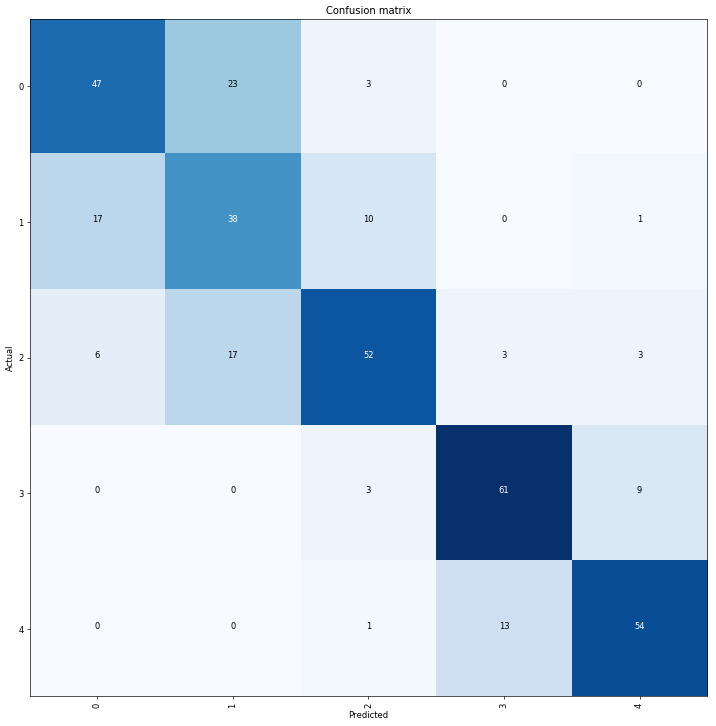

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
learn.save('stage-1-224')

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


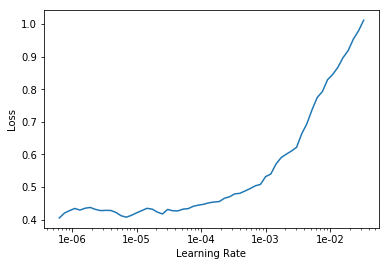

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.452753,0.726665,0.698061,0.887546
2,0.432958,0.737851,0.695291,0.888217
3,0.431558,0.755752,0.695291,0.888608
4,0.400223,0.736860,0.720222,0.894160
5,0.381495,0.755267,0.700831,0.887361
6,0.340749,0.737205,0.720222,0.890975
7,0.345960,0.730080,0.734072,0.895755
8,0.320470,0.730521,0.736842,0.897740


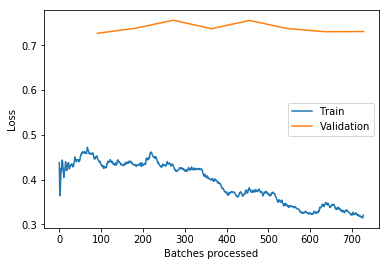

In [32]:
learn.recorder.plot_losses()

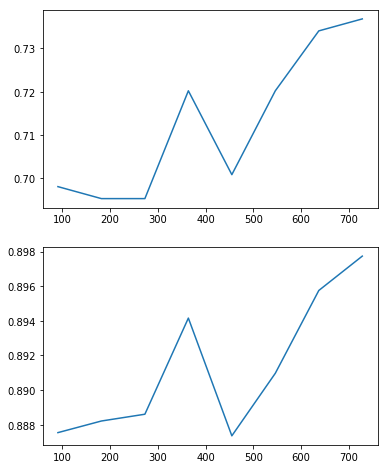

In [33]:
learn.recorder.plot_metrics()

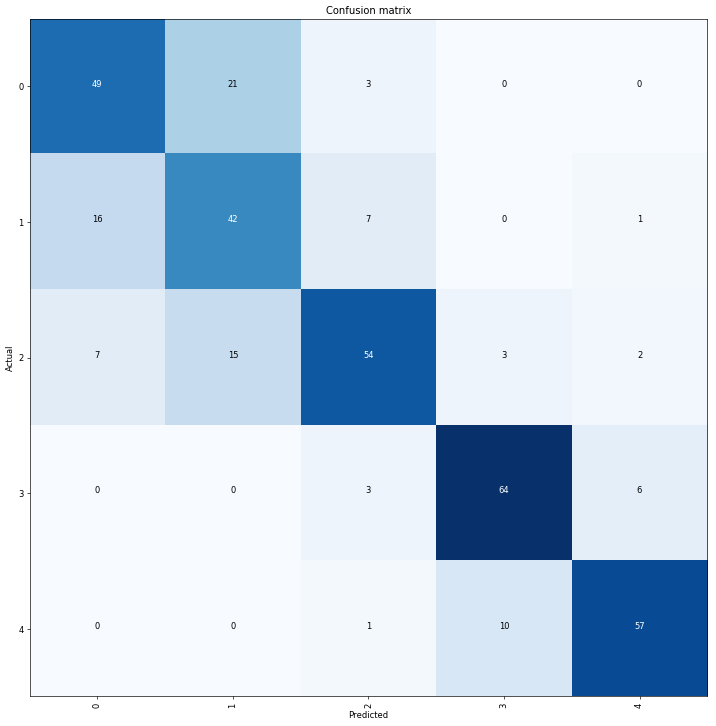

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [35]:
learn.save('stage-2-224')

In [36]:
data = (src.transform(tfms,size=sz*2) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [37]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [38]:
learn.freeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


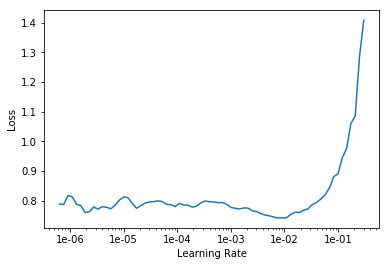

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(8,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.671404,0.823595,0.667590,0.866354
2,0.562854,0.794155,0.695291,0.875752
3,0.506637,0.765987,0.700831,0.885686
4,0.430203,0.755895,0.709141,0.882888
5,0.362881,0.751121,0.709141,0.883786
6,0.311483,0.704895,0.750693,0.900827
7,0.265374,0.695593,0.734072,0.896550
8,0.245734,0.695073,0.750693,0.900011


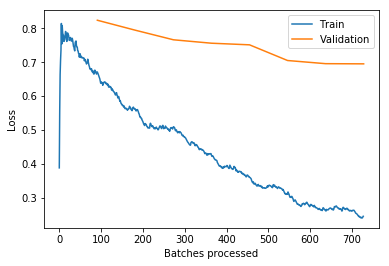

In [42]:
learn.recorder.plot_losses()

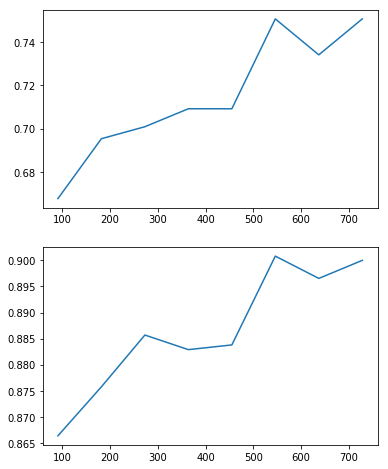

In [43]:
learn.recorder.plot_metrics()

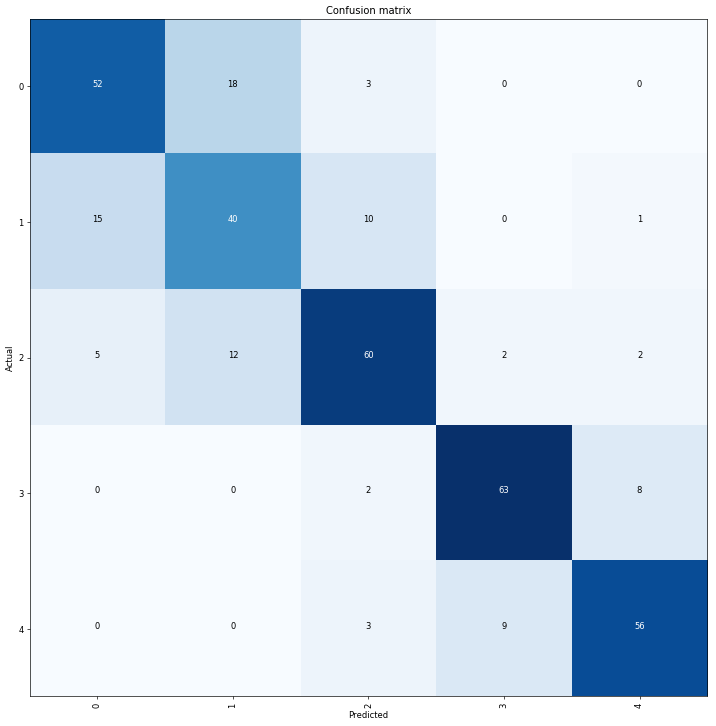

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [45]:
learn.save('stage-1-448')

In [46]:
learn.unfreeze()

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


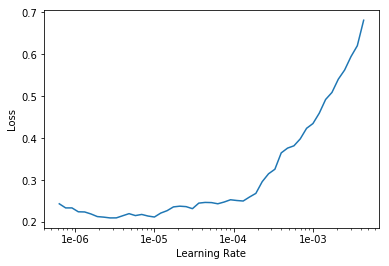

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(8,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.250878,0.682843,0.747922,0.898573
2,0.249090,0.706359,0.770083,0.906833
3,0.237254,0.676439,0.772853,0.909053
4,0.225532,0.677328,0.770083,0.914854
5,0.183969,0.676475,0.761773,0.905871
6,0.178617,0.694838,0.750693,0.906364
7,0.167090,0.669854,0.778393,0.915418
8,0.163267,0.676202,0.772853,0.915884


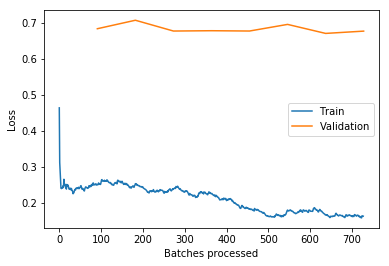

In [50]:
learn.recorder.plot_losses()

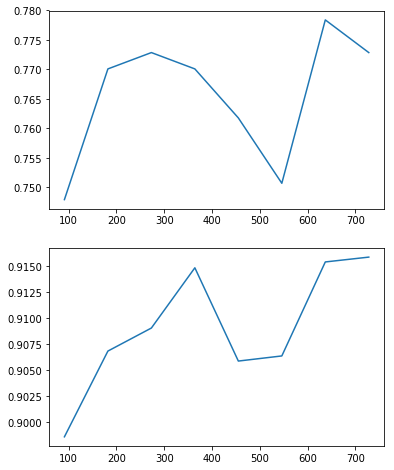

In [51]:
learn.recorder.plot_metrics()

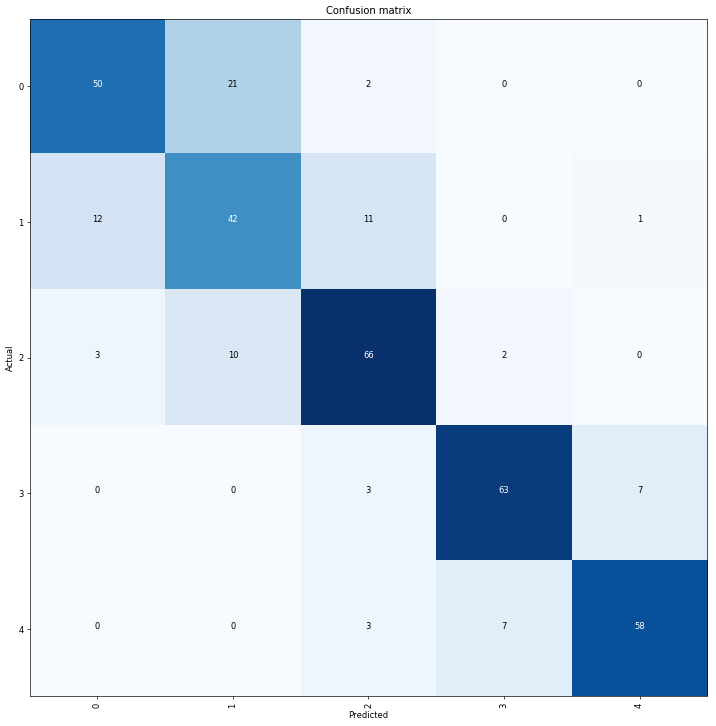

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [53]:
learn.save('stage-2-448')

In [54]:
base_image_dir = '../input/aptos-augmented/aptos/upload/'
df = pd.read_csv('../input/aptos-augmented/aptos.csv')
df.columns = ['image', 'level']
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.png'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,2,../input/aptos-augmented/aptos/upload/653534de...
1,0,../input/aptos-augmented/aptos/upload/5db2e3a4...
2,4,../input/aptos-augmented/aptos/upload/db42d497...
3,0,../input/aptos-augmented/aptos/upload/1caba2fb...
4,4,../input/aptos-augmented/aptos/upload/f58d37d4...
5,4,../input/aptos-augmented/aptos/upload/c63c9f6d...
6,0,../input/aptos-augmented/aptos/upload/8f06ca46...
7,1,../input/aptos-augmented/aptos/upload/bb02e293...
8,4,../input/aptos-augmented/aptos/upload/c6d96fcd...
9,0,../input/aptos-augmented/aptos/upload/5b470439...


In [55]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.1)

In [56]:
train_df, set1 = train_test_split(train_df,test_size=0.2)
train_df, set2 = train_test_split(train_df,test_size=0.25)
train_df, set3 = train_test_split(train_df,test_size=0.35)
set5, set4 = train_test_split(train_df,test_size=0.5)

In [63]:
bs = 32
sz = 256

df_train = pd.concat([set2, set3, set4, set5])
# df_train = balance_data(df_train.pivot_table(index='level', aggfunc=len).max().max(),df_train)
df = pd.concat([df_train, val_df])

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(df_train)-1, len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

learn.data = data

learn.freeze()
learn.fit_one_cycle(1, max_lr=1e-3)

learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.195923,0.176243,0.941059,0.966784


epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.163658,0.175029,0.942058,0.974770


In [64]:
bs = 32
sz = 256

df_train = pd.concat([set1, set3, set4, set5])
# df_train = balance_data(df_train.pivot_table(index='level', aggfunc=len).max().max(),df_train)
df = pd.concat([df_train, val_df])

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(df_train)-1, len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

learn.data = data

learn.freeze()
learn.fit_one_cycle(1,max_lr=1e-3)

learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.178611,0.184473,0.935065,0.968765


epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.155944,0.175958,0.942058,0.975478


In [65]:
bs = 32
sz = 256

df_train = pd.concat([set1, set2, set4, set5])
# df_train = balance_data(df_train.pivot_table(index='level', aggfunc=len).max().max(),df_train)
df = pd.concat([df_train, val_df])

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(df_train)-1, len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

learn.data = data

learn.freeze()
learn.fit_one_cycle(1,max_lr=1e-3)

learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.181137,0.184125,0.939061,0.970710


epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.146898,0.163547,0.944056,0.976587


In [66]:
bs = 32
sz = 256

df_train = pd.concat([set1, set2, set3, set5])
# df_train = balance_data(df_train.pivot_table(index='level', aggfunc=len).max().max(),df_train)
df = pd.concat([df_train, val_df])

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(df_train)-1, len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

learn.data = data

learn.freeze()
learn.fit_one_cycle(1,max_lr=1e-3)

learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.175812,0.163569,0.941059,0.973586


epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.141817,0.157425,0.948052,0.977723


In [67]:
bs = 32
sz = 256

df_train = pd.concat([set1, set2, set3, set4])
# df_train = balance_data(df_train.pivot_table(index='level', aggfunc=len).max().max(),df_train)
df = pd.concat([df_train, val_df])

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(df_train)-1, len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

learn.data = data

learn.freeze()
learn.fit_one_cycle(1,max_lr=1e-3)

learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.175803,0.168354,0.941059,0.971246


epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.148956,0.164939,0.941059,0.971965


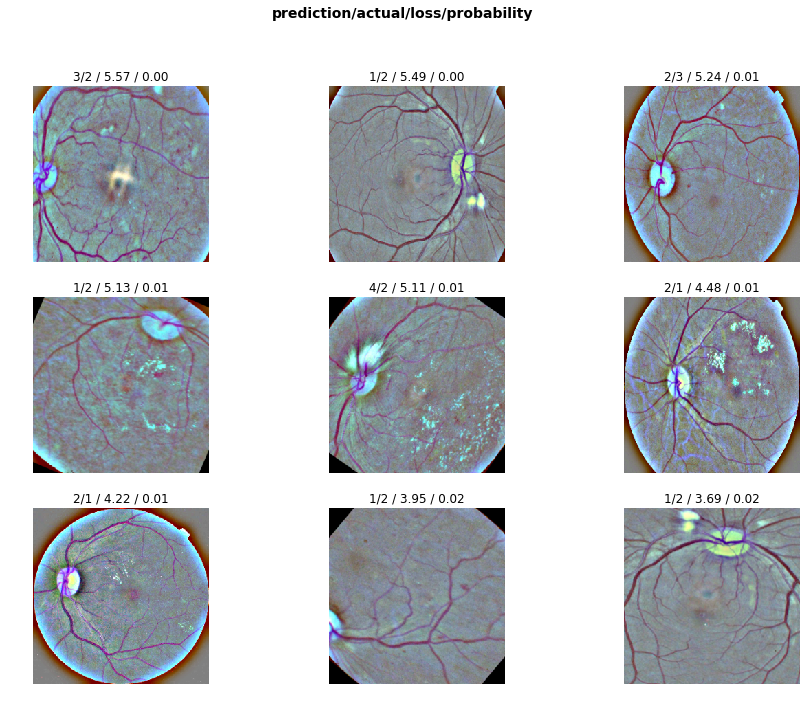

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

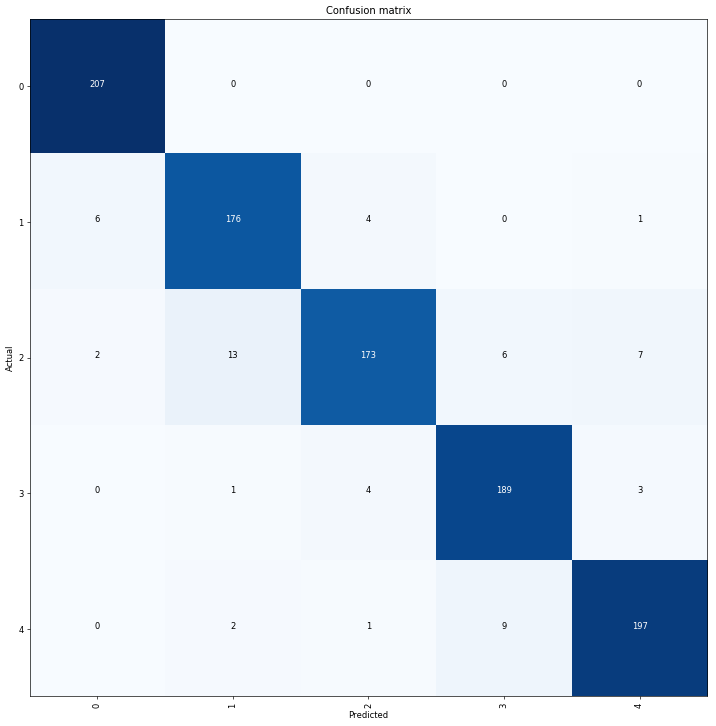

In [69]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)